# Simple Time Series Example

This tutorial demonstrates how quasi-stationary time series analysis can be done with pandapipes. In the following, an already existing net is loaded from a json file. The prerequisites for a successful execution of a time series simulation are:

- a pandapipes network
- predefined time series for the sinks and sources in the network (e.g. 2 csv files)

In this example, the following pandapipes network is loaded:

<img src="pics/time_series_simple_example_network.png">

The following modules are imported first

In [1]:
import os
import pandas as pd
import pandapower.control as control
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapipes.timeseries import run_timeseries

Not that the time series functionality is provided by the pandapower module. But because the structure of pandapipes is similar to the one of pandapower, we can use the same functions here. 

With the following import statement, stored networks can be loaded.

In [2]:
from pandapipes import networks

The loading procedure is started with this function call:

In [3]:
net = networks.simple_gas_networks.gas_meshed_delta()

This is the delta STANET network from the chapter [Meshed Networks](https://pandapipes.readthedocs.io/en/latest/networks/meshed/meshed_networks.html) with the medium gas.

In this example, time series data for the sink and source components is added. For every provided data point, an own pandapipes calculation will be executed. This is of course done automatically. Thus, the number of time steps in this case is 10. Since there is only one sink and one source, the respective csv file only consists of one column.

<img src="pics/time_series_simple_example_csv_files.png">

With the code

In [4]:
profiles_sink = pd.read_csv(os.path.join('files',
                                         'simple_time_series_example_sink_profiles.csv'),
                                         index_col=0)
profiles_source = pd.read_csv(os.path.join('files',
                                           'simple_time_series_example_source_profiles.csv'),
                                           index_col=0)
ds_sink = DFData(profiles_sink)
ds_source = DFData(profiles_source)

const_sink = control.ConstControl(net, element='sink', variable='mdot_kg_per_s',
                                  element_index=net.sink.index.values, data_source=ds_sink,
                                  profile_name=net.sink.index.values.astype(str))
const_source = control.ConstControl(net, element='source', variable='mdot_kg_per_s',
                                    element_index=net.source.index.values,
                                    data_source=ds_source,
                                    profile_name=net.source.index.values.astype(str))

the corresponding csv-file is read out, prepared as data sources (ds) for the controllers and the resulting DataFrames are written into the network with the help of the controller [ConstControl](https://pandapower.readthedocs.io/en/v2.2.2/control/controller.html#constcontrol). Then the desired time steps for which the network is to be calculated must be specified. In the present case, these can be defined from 1 to 10 at most, since only 10 time steps are specified for the sink and source. Likewise, for example, a range of 3 to 6 can be specified. Here the time steps from 1 to 10 are defined with

In [5]:
time_steps = range(10)

Furthermore an [OuputWriter](https://pandapower.readthedocs.io/en/v2.2.2/timeseries/output_writer.html) must be created, which is defined as `ow` using

In [6]:
log_variables = [('res_junction', 'p_bar'), ('res_pipe', 'v_mean_m_per_s'),
                 ('res_pipe', 'reynolds'), ('res_pipe', 'lambda'),
                 ('res_sink', 'mdot_kg_per_s'), ('res_source', 'mdot_kg_per_s'),
                 ('res_ext_grid', 'mdot_kg_per_s')]
ow = OutputWriter(net, time_steps, output_path=None, log_variables=log_variables)

In the output writer the results of the simulation are stored. Finally, the main function can be called to run the time series simulation:

In [7]:
run_timeseries(net, time_steps)

Progress: |██████████████████████████████████████████████████| 100.0% Complete



The results of the simulation can be accessed via the OutputWriter as follows:

In [8]:
print("pressure:")
print(ow.np_results["res_junction.p_bar"])
print("mean velocity:")
print(ow.np_results["res_pipe.v_mean_m_per_s"])
print("reynolds number:")
print(ow.np_results["res_pipe.reynolds"])
print("lambda:")
print(ow.np_results["res_pipe.lambda"])
print("mass flow sink:")
print(ow.np_results["res_sink.mdot_kg_per_s"])
print("mass flow source:")
print(ow.np_results["res_source.mdot_kg_per_s"])
print("mass flow ext. grid:")
print(ow.np_results["res_ext_grid.mdot_kg_per_s"])

pressure:
[[3.49975257 3.5        3.49961173]
 [3.49973649 3.5        3.49949785]
 [3.49972162 3.5        3.49936071]
 [3.49970758 3.5        3.49920016]
 [3.49969414 3.5        3.4990161 ]
 [3.49968112 3.5        3.49880846]
 [3.49966839 3.5        3.49857714]
 [3.49965585 3.5        3.4983221 ]
 [3.49964345 3.5        3.49804329]
 [3.49963112 3.5        3.49774068]]
mean velocity:
[[-0.57651001 -0.49611582 -0.21696278]
 [-0.76534799 -0.51363216 -0.25383547]
 [-0.95276066 -0.5293793  -0.2932576 ]
 [-1.13916058 -0.54386481 -0.33449866]
 [-1.32480882 -0.55740925 -0.37709744]
 [-1.5099034  -0.57025531 -0.42070489]
 [-1.69457795 -0.58256615 -0.46508642]
 [-1.87893324 -0.59446437 -0.51006588]
 [-2.06302946 -0.60602249 -0.55553927]
 [-2.24692628 -0.61731235 -0.60140351]]
reynolds number:
[[17616.51199081 13644.68760488  4971.54745982]
 [23386.16464632 14126.19817054  5816.74628673]
 [29112.07624708 14559.10756425  6720.26651999]
 [34807.4075172  14958.03881282  7664.56052742]
 [40478.688170

To view the results more clearly, they can be displayed with `matplotlib.pyplot` in a diagram with the time steps as x-axis.The time curve for the mass flow in the External Grid looks as follows:

<img src="pics/time_series_simple_example_plot_mass_flow_ext_grid.png">

The figure can be created by the following lines:

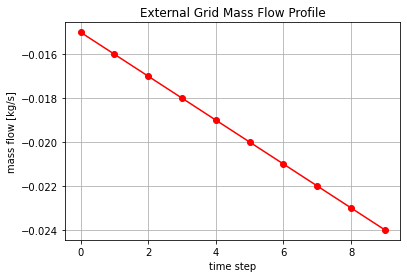

In [9]:
import matplotlib.pyplot as plt

x = time_steps
y = ow.np_results["res_ext_grid.mdot_kg_per_s"]

plt.xlabel("time step")
plt.ylabel("mass flow [kg/s]")
plt.title("External Grid Mass Flow Profile")
plt.plot(x, y, "r-o")
plt.grid()
plt.show()

In addition, the pressure curves for the individual junctions can be plotted with this code block:

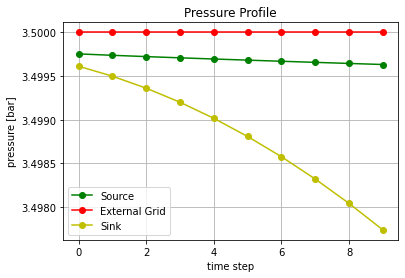

In [10]:
import matplotlib.pyplot as plt

x = time_steps
y = ow.np_results["res_junction.p_bar"]

plt.xlabel("time step")
plt.ylabel("pressure [bar]")
plt.title("Pressure Profile")
plt.plot(x, y[:,0], "g-o")
plt.plot(x, y[:,1], "r-o")
plt.plot(x, y[:,2], "y-o")
plt.legend(["Source", "External Grid", "Sink"], loc='lower left')
plt.grid()
plt.show()

<img src="pics/time_series_simple_example_plot_pressures.png">

As a final example to illustrate the results, the flow velocities of the three pipes are plotted:

<img src="pics/time_series_simple_example_plot_velocities.png">

For this purpose, the following code must be executed:

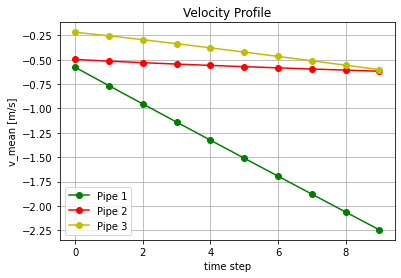

In [11]:
import matplotlib.pyplot as plt

x = time_steps
y = ow.np_results["res_pipe.v_mean_m_per_s"]

plt.xlabel("time step")
plt.ylabel("v_mean [m/s]")
plt.title("Velocity Profile")
plt.plot(x, y[:,0], "g-o")
plt.plot(x, y[:,1], "r-o")
plt.plot(x, y[:,2], "y-o")
plt.legend(["Pipe 1", "Pipe 2", "Pipe 3"], loc='lower left')
plt.grid()
plt.show()